In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from typing import Union
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, LSTM

from figure_labeler import *
fl = FigureLabeler();
pd.options.mode.chained_assignment = None

from IPython.display import HTML
HTML('''
<script
    src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js ">
</script>
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
 } else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit"
    value="Click here to toggle on/off the raw code."></form>
''')

<h1 style="text-align:center;">Forecasting Taxi Demand: A Hybrid Approach of ARMA and Deep Learning for October to December Predictions</h1>
<hr>

<a name="top"></a>
#### Table of Contents:

[ref0]: #abs
- [Abstract][ref0]

[ref1]: #prob_stat
- [Problem Statement][ref1]

[ref2]: #dat_prep
- [Data Preprocessing][ref2]

[ref3]: #dat_expl
- [Data Exploration][ref3]

[ref4]: #res_dis
- [Results and Discussions][ref4]

[ref5]: #conc
- [Conclusion and Recommendations][ref5]

<a name="abs"></a>
## Abstract
This section provides a short summary of the whole notebook. Problem statement and significant insights are briefly discussed.
***

This study focuses on performing data cleaning, exploratory data analysis (EDA), and building predictive models for taxi demand using the ARMA and Deep Learning approaches. The dataset covers taxi demand from October to December, and models are constructed utilizing sklearn and TensorFlow. The objective is to accurately predict taxi demand during the specified period, employing machine learning techniques to address the problem statement effectively.


[ref]: #top
[Back to Table of Contents][ref]

<a name="prob_stat"></a>
## Problem Statement
This section discusses the description of the problem that needs to be addressed. 
***

We aim to create two models, ARMA and Deep Learning, using *sklearn* and *tensorflow* to **predict taxi demand from October to December**.



[ref]: #top
[Back to Table of Contents][ref]

<a name="dat_prep"></a>
## Data Preprocessing
This section shows the preparation of the dataset before using for exploration and analysis
***

In [2]:
fl.table_caption("Taxi Dataframe",
                 "Loading the Taxi dataset and showing the columns as well as the the first and last five rows")

df = dd.read_csv('taxi_final.csv', sample_rows=10000000, dtype={'DestinationStreetNumber': 'object',
       'DestinationZip': 'object',
       'OriginStreetNumber': 'object',
       'OriginZip': 'object',
       'PaymentType': 'float64',
       'Type': 'object'})

display(df)

,Type,PROVIDER NAME,StartDateTime,DateCreated,ID,ExternalID,FareAmount,GratuityAmount,SurchargeAmount,ExtraFareAmount,TollAmount,TotalAmount,PaymentType,StartDateTime.1,EndDateTime,OriginStreetNumber,OriginStreetName,OriginCity,OriginState,OriginZip,OriginLatitude,OriginLongitude,DestinationStreetNumber,DestinationStreetName,DestinationCity,DestinationState,DestinationZip,DestinationLatitude,DestinationLongitude,Milage,Duration,Unnamed: 31
npartitions=65,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,object,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,float64,float64,object,object,object,object,object,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [3]:
fl.table_caption("The States",
                 "Printing a list the states from the OriginState columns")

list_of_states = df['OriginState'].value_counts()

# Print the unique values
print(list_of_states.compute())

C:\ProgramData\anaconda3\Lib\site-packages\dask\dataframe\io\csv.py:195: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\dask\dataframe\io\csv.py:195: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\dask\dataframe\io\csv.py:195: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\dask\dataframe\io\csv.py:195: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\dask\dataframe\io\csv.py:195: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, 

OriginState
DC    8337084
--    1853009
VA     549018
VI      91029
NE      65454
MD      50573
WA      11524
MT       2776
CT        636
NY        624
IN        210
DE        184
AR         53
MA         40
PA         29
NJ         26
CA         20
HI         16
AS          8
CO          6
LA          6
ME          5
AL          4
OR          3
WV          2
NC          1
MO          1
AK          1
MS          1
Name: count, dtype: int64


In [4]:
fl.table_caption("Filtering Rows",
                 "The rows VA in the OriginState and DestinationState columns are filtered and revealed")

df_va = df.loc[(df['OriginState'] == 'VA') & (df['DestinationState'] == 'VA')]
df_va = df_va.compute()

df_va.info()

C:\ProgramData\anaconda3\Lib\site-packages\dask\dataframe\io\csv.py:195: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\dask\dataframe\io\csv.py:195: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\dask\dataframe\io\csv.py:195: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\dask\dataframe\io\csv.py:195: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\dask\dataframe\io\csv.py:195: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, 

<class 'pandas.core.frame.DataFrame'>
Index: 72985 entries, 9 to 177090
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     72985 non-null  object 
 1   PROVIDER NAME            72985 non-null  object 
 2   StartDateTime            72985 non-null  object 
 3   DateCreated              72985 non-null  object 
 4   ID                       72985 non-null  object 
 5   ExternalID               72985 non-null  object 
 6   FareAmount               72985 non-null  float64
 7   GratuityAmount           72982 non-null  float64
 8   SurchargeAmount          72982 non-null  float64
 9   ExtraFareAmount          72982 non-null  float64
 10  TollAmount               72982 non-null  float64
 11  TotalAmount              72985 non-null  float64
 12  PaymentType              72985 non-null  float64
 13  StartDateTime.1          72985 non-null  object 
 14  EndDateTime              7

In [5]:
df_va = df_va.dropna(axis=1, how='all')
df_va = df_va.drop('StartDateTime.1', axis=1)

In [6]:
df_va['DateCreated'] = pd.to_datetime(df_va['DateCreated'])
df_va['StartDateTime'] = pd.to_datetime(df_va['StartDateTime'])
df_va['EndDateTime'] = pd.to_datetime(df_va['EndDateTime'])

In [7]:
df_va = df_va.sort_values(by='StartDateTime').reset_index(drop=True)

In [8]:
df_va['hour'] = df_va['StartDateTime'].dt.hour
df_va['day_of_week'] = df_va['StartDateTime'].dt.day_name()
df_va['date'] = df_va['StartDateTime'].dt.date

# Group by hour and day of the week, and count the number of occurrences
grouped_df = df_va.groupby(['hour', 'day_of_week']).size().reset_index(name='count')

# Pivot the DataFrame to get the count for each hour and day of the week
pivot_df = grouped_df.pivot(index='hour', columns='day_of_week', values='count')

# Reorder the columns to have the days in the correct order
pivot_df = pivot_df[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

In [9]:
fl.table_caption("Taxi Demand by Hour",
                 "The table represents which hour of the day has the highest demand for the taxi ")

display(pivot_df)

day_of_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
hour,,,,,,,
0,341,251,210,226,284,491,649
1,196,107,145,148,190,433,592
2,167,76,98,86,135,462,724
3,88,46,53,42,72,344,495
4,62,54,78,69,116,202,264
5,118,86,110,122,145,160,177
6,147,125,136,178,211,143,202
7,280,247,278,290,256,164,239
8,518,367,522,314,277,209,240


[ref]: #top
[Back to Table of Contents][ref]

<a name="dat_expl"></a>
## Data Exploration
This section demonstrates that the dataframe is manipulated to extract the needed values.  By coding, a graphical representation of the data is possible.
***

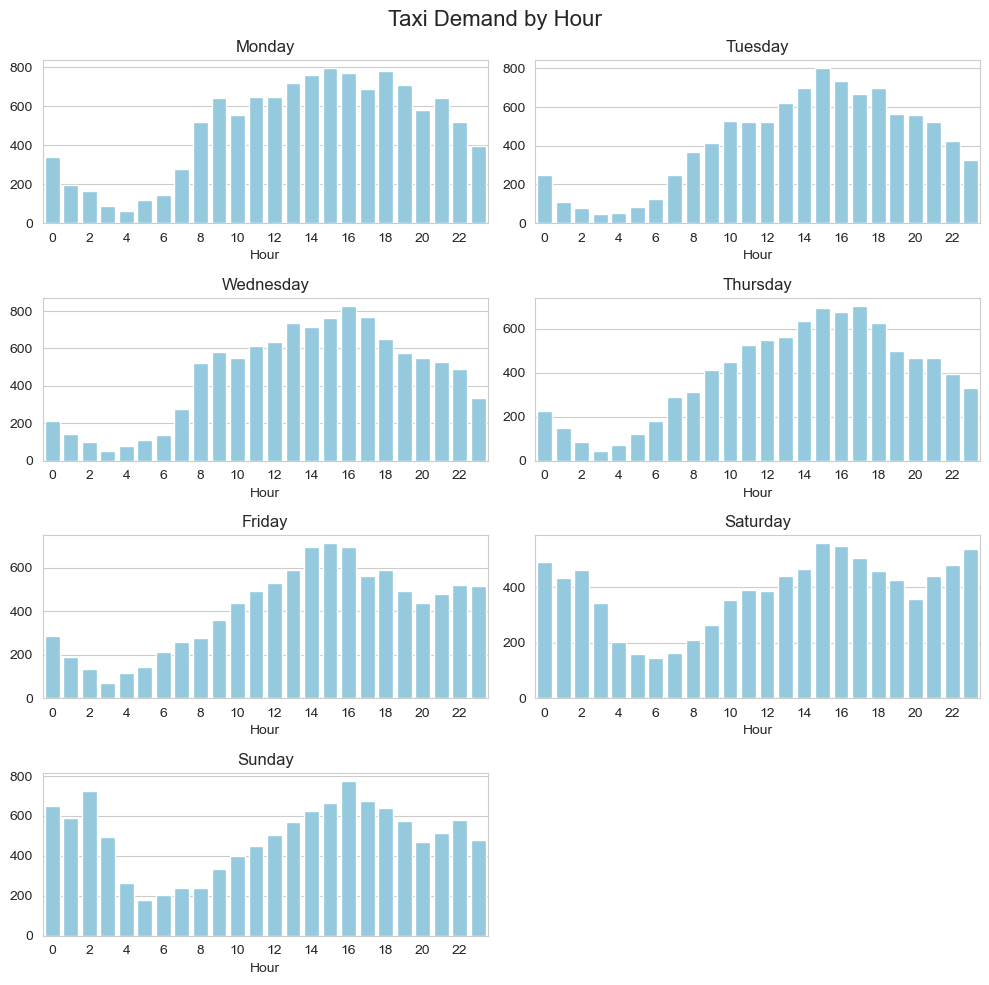

In [10]:
fl.fig_caption("Daily Taxi Demand by Hour Histogram",
               "A histogram displaying the distribution of demand every hour in each day of the week is exhibited")

num_cols = 2
num_rows = (len(pivot_df.columns) + num_cols - 1) // num_cols

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each column and create a bar plot
for i, column in enumerate(pivot_df.columns):
    sns.barplot(x=pivot_df.index, y=pivot_df[column], ax=axes[i], color='skyblue')
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel('Hour')
    axes[i].set_ylabel('')

    tick_positions = np.arange(0, len(pivot_df.index), 2)  # Every second tick
    tick_labels = pivot_df.index[::2]  # Corresponding labels
    axes[i].set_xticks(tick_positions)
    axes[i].set_xticklabels(tick_labels)

# Remove any unused subplots
for i in range(len(pivot_df.columns), num_rows * num_cols):
    fig.delaxes(axes[i])

fig.suptitle('Taxi Demand by Hour', fontsize=16)

# Adjust the layout to prevent overlapping
plt.tight_layout()
# Show the plot
plt.show()

**Observations: Weekdays have a different distribution from weekends**

In [11]:
counts = df_va.groupby('date').size()
counts.index = pd.to_datetime(counts.index)

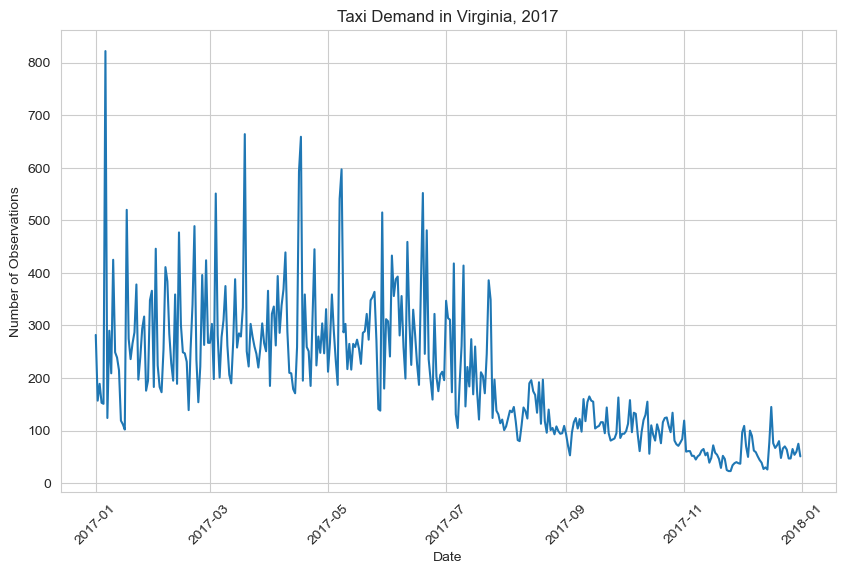

In [12]:
fl.fig_caption("Taxi Demand in Virginia Lineplot",
               "A lineplot displaying the number of observations in demand through out 2017 is produced")

plt.figure(figsize=(10, 6))
sns.lineplot(data=counts, x=counts.index, y=counts.values)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Number of Observations')
plt.title('Taxi Demand in Virginia, 2017')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [13]:
fl.table_caption("wait hold up",
                 "insert somestuff here")

taxi_demand_df = counts.reset_index().rename(columns={0: 'count'})
taxi_demand_df['date'] = pd.to_datetime(taxi_demand_df['date'])
taxi_demand_df.set_index('date', inplace=True)
taxi_demand_df.head()

,count
date,
2017-01-01,282
2017-01-02,157
2017-01-03,189
2017-01-04,153
2017-01-05,151


In [14]:
ADF_result = adfuller(taxi_demand_df['count'])
if (ADF_result[1] > 0.05):
    print('Taxi demand time series is not stationary.')
else:
    print('Taxi demand time series is stationary')

Taxi demand time series is not stationary.


In [15]:
first_diff = np.diff(taxi_demand_df['count'], n=1)
ADF_result = adfuller(first_diff)
if (ADF_result[1] > 0.05):
    print('Taxi demand time series is not stationary.')
else:
    print('Taxi demand time series is stationary')

Taxi demand time series is stationary


In [16]:
fl.table_caption("Calculating, Naming, and Filling",
                 "Resetting the index of counts and renaming it to 'count'."
                 "Calculates the first difference of the time series, assigns it to a new column, fills missing values")

df_diff = pd.DataFrame({'First difference': first_diff}, index=taxi_demand_df.index[1:])
taxi_demand_df['First diff'] = df_diff
taxi_demand_df['First diff'] = taxi_demand_df['First diff'].fillna(0)
taxi_demand_df.head()

,count,First diff
date,,
2017-01-01,282,0.0
2017-01-02,157,-125.0
2017-01-03,189,32.0
2017-01-04,153,-36.0
2017-01-05,151,-2.0


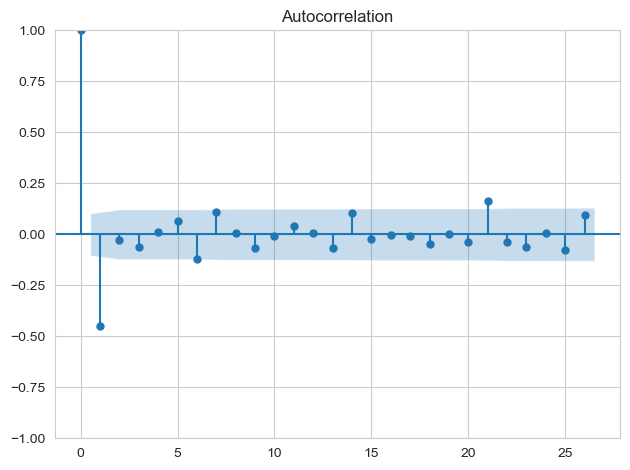

In [17]:
fl.fig_caption("Visualizing Autocorrelation of Taxi Demand Time Series Data",
               "Plotting the Autocorrelation Function (ACF) of First Order Differences")


plot_acf(taxi_demand_df['First diff'])

plt.tight_layout()

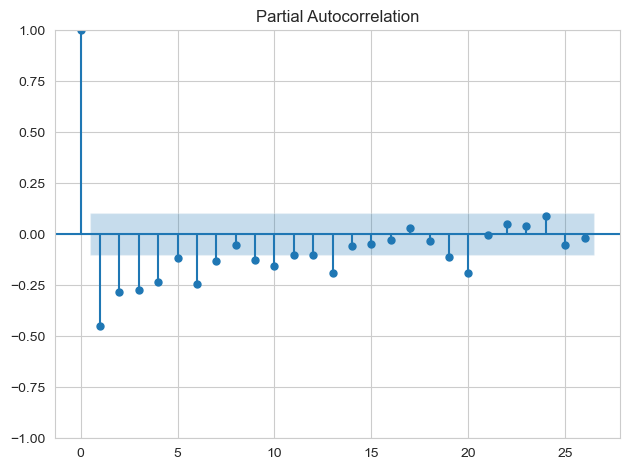

In [18]:
fl.fig_caption("Visualizing Partial Autocorrelation of Taxi Demand Time Series Data",
               "Plotting the Partial Autocorrelation Function (PACF) of First Order Differences")

plot_pacf(taxi_demand_df['First diff'])

plt.tight_layout()

In [19]:
train = taxi_demand_df.iloc[:int(0.8*len(taxi_demand_df))]
test = taxi_demand_df.iloc[-int(0.2*len(taxi_demand_df)):]

In [20]:
fl.table_caption("Train Table",
                 "Displays the training data")

train

,count,First diff
date,,
2017-01-01,282,0.0
2017-01-02,157,-125.0
2017-01-03,189,32.0
2017-01-04,153,-36.0
2017-01-05,151,-2.0
...,...,...
2017-10-15,110,54.0
2017-10-16,92,-18.0
2017-10-17,81,-11.0


In [21]:
fl.table_caption("Train Test",
                 "Displays the testing data")

test

,count,First diff
date,,
2017-10-20,76,-23.0
2017-10-21,116,40.0
2017-10-22,124,8.0
2017-10-23,125,1.0
2017-10-24,109,-16.0
...,...,...
2017-12-27,65,18.0
2017-12-28,54,-11.0
2017-12-29,60,6.0


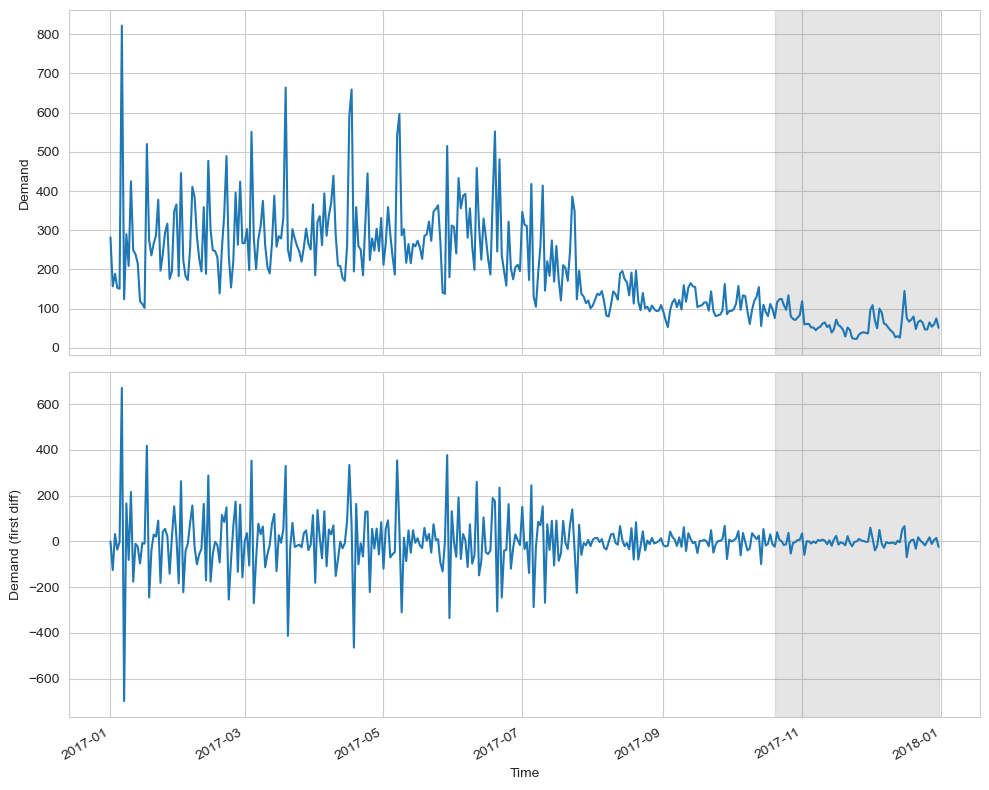

In [22]:
fl.fig_caption("Visualizing Taxi Demand Time Series Data and First Order Differences",
               "Comparing Total Demand and First Order Differences Over Time")

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(taxi_demand_df['count'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Demand')
ax1.axvspan('2017-10-20', '2017-12-31', color='#808080', alpha=0.2)

ax2.plot(taxi_demand_df['First diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Demand (first diff)')
ax2.axvspan('2017-10-20', '2017-12-31', color='#808080', alpha=0.2)
fig.autofmt_xdate()
plt.tight_layout()

In [23]:
def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    results = []
    for order in order_list:
        try:
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [24]:
ps = [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 19, 20]
qs = [0, 1, 6, 7, 21]

order_list = list(product(ps, qs))

In [25]:
fl.table_caption("SARIMA Model Summary for Taxi Demand Time Series Data",
                 "Optimizing ARMA Parameters Using Akaike Information Criterion (AIC)")

aic_df = optimize_ARMA(train['First diff'], order_list)
aic_df

,"(p,q)",AIC
0,"(4, 21)",3496.984326
1,"(0, 7)",3498.348414
2,"(2, 7)",3498.981713
3,"(4, 7)",3499.127534
4,"(1, 7)",3500.329857
...,...,...
70,"(4, 0)",3545.061067
71,"(3, 0)",3560.180647
72,"(2, 0)",3581.083046
73,"(1, 0)",3603.425623


In [26]:
fl.table_caption("Model Selection with AIC for ARMA Time Series Analysis",
                 "Model Fit and Summary Statistics for SARIMA(4,0,21) with Complex Differencing")

model = SARIMAX(train['First diff'], order=(4,0,21), simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             First diff   No. Observations:                  292
Model:              SARIMAX(4, 0, 21)   Log Likelihood               -1722.492
Date:                Sun, 24 Mar 2024   AIC                           3496.984
Time:                        21:31:08   BIC                           3592.580
Sample:                    01-01-2017   HQIC                          3535.276
                         - 10-19-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6208      0.100     -6.216      0.000      -0.816      -0.425
ar.L2         -0.5309      0.094     -5.675      0.000      -0.714      -0.348
ar.L3         -0.3490      0.096     -3.653      0.0

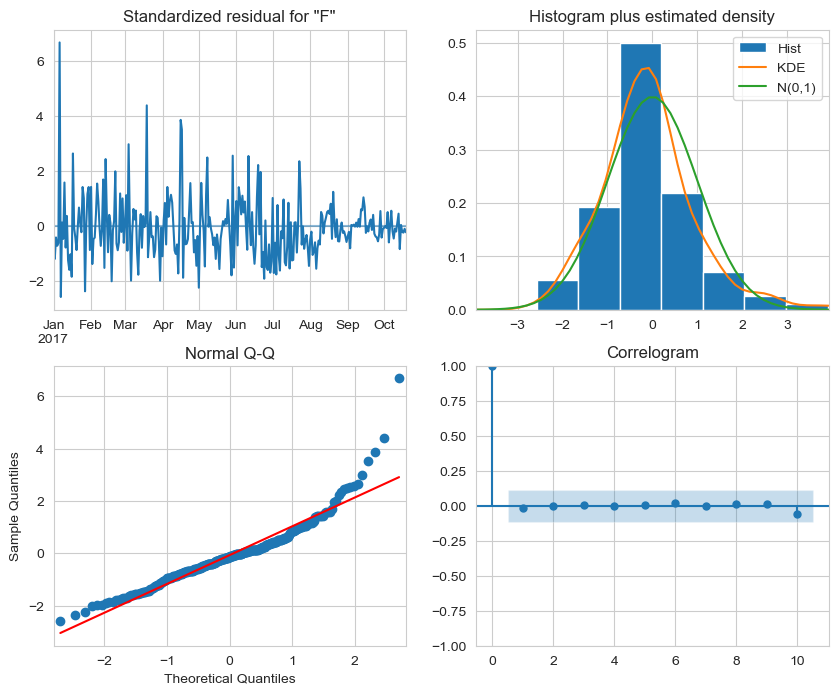

In [27]:
fl.fig_caption("Diagnostic Plots for SARIMA Model",
               "Assessing Model Fit and Residuals")

model_fit.plot_diagnostics(figsize=(10, 8));

**All plots indicate that the residuals are not correlated.**

In [28]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_ARMA = []

for i in range(TRAIN_LEN, TRAIN_LEN + HORIZON, WINDOW):
    model = SARIMAX(taxi_demand_df['First diff'][:i], order=(4,0,21))
    res = model.fit(disp=False)
    predictions = res.get_prediction(0, i + WINDOW - 1)
    oos_pred = predictions.predicted_mean.iloc[-WINDOW:]
    pred_ARMA.extend(oos_pred)

pred_ARMA

[5.150258625621366,
 27.090218947213764,
 -16.329232319417937,
 -21.368559104313675,
 -10.521155502932496,
 -1.3058016884134958,
 -1.0695542226063184,
 -20.744652014845055,
 20.213475797865808,
 20.153293168373846,
 21.17641789647169,
 9.377515574153222,
 1.411279153312873,
 5.885496371458899,
 54.99282130764473,
 23.50171655791083,
 49.287091063118154,
 41.8262345133695,
 32.65819685205238,
 59.144243175376864,
 26.24730407392181,
 17.576355061042214,
 29.252536666741005,
 20.3418503856596,
 39.52070313080322,
 20.17604853890437,
 41.43971970267097,
 26.44514659826456,
 -20.62265927187605,
 -1.4665693144911067,
 -0.6132452281346086,
 11.178170997195394,
 53.85505554239852,
 15.290262830739474,
 -4.488457758642263,
 23.85076433878126,
 19.799273484305683,
 18.139272475230285,
 15.987252841784805,
 -7.449356980573182,
 -8.968011909729729,
 9.341505871479447,
 6.710553591829845,
 -51.06953353699143,
 -70.69443202595207,
 -52.98713361358659,
 -30.412051320070663,
 -73.4357206366187,
 -58.

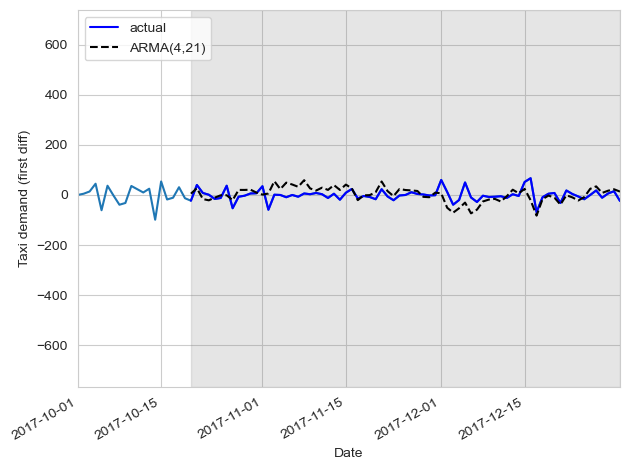

In [29]:
fl.fig_caption("Comparison of Actual and Predicted Taxi Demand Using ARMA Model",
               "Visualizing Model Performance for ARMA(4,21) on Test Data")


test.loc[:, 'pred_ARMA'] = pred_ARMA

fig, ax = plt.subplots()
ax.plot(taxi_demand_df['First diff'])
ax.plot(test['First diff'], 'b-', label='actual')
ax.plot(test['pred_ARMA'], 'k--', label='ARMA(4,21)')
ax.legend(loc=2)
ax.set_xlabel('Date')
ax.set_ylabel('Taxi demand (first diff)')

ax.axvspan('2017-10-20', '2017-12-31', color='#808080', alpha=0.2)
ax.set_xlim(pd.to_datetime('2017-10-01'), pd.to_datetime('2017-12-31'))

fig.autofmt_xdate()
plt.tight_layout()

In [30]:
fl.table_caption("Predicted Taxi Demand Using ARMA Model",
                 "Incorporating ARMA Model Forecasts into Overall Demand Prediction")

taxi_demand_df['pred_demand'] = taxi_demand_df['count'].iloc[291] + test['pred_ARMA'].cumsum()
taxi_demand_df

,count,First diff,pred_demand
date,,,
2017-01-01,282,0.0,NaN
2017-01-02,157,-125.0,NaN
2017-01-03,189,32.0,NaN
2017-01-04,153,-36.0,NaN
2017-01-05,151,-2.0,NaN
...,...,...,...
2017-12-27,65,18.0,220.923764
2017-12-28,54,-11.0,229.158594
2017-12-29,60,6.0,246.189926


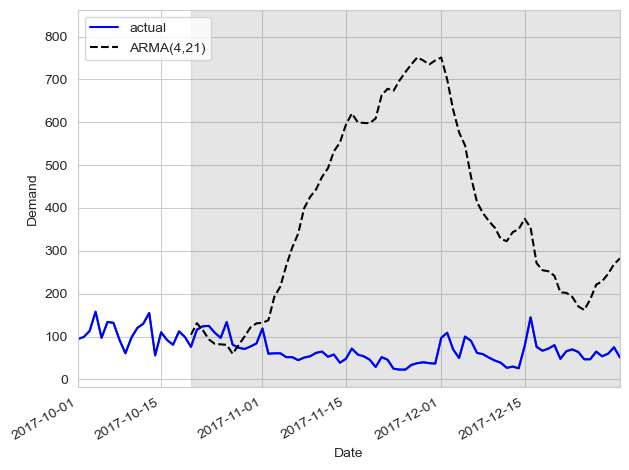

In [31]:
fl.fig_caption("Actual vs Predicted Taxi Demand Incorporating ARMA Model Forecasts",
               "Comparing Actual Demand with Predicted Demand Using ARMA(4,21) Model")

fig, ax = plt.subplots()

ax.plot(taxi_demand_df['count'])
ax.plot(taxi_demand_df['count'], 'b-', label='actual')
ax.plot(taxi_demand_df['pred_demand'], 'k--', label='ARMA(4,21)')

ax.legend(loc=2)

ax.set_xlabel('Date')
ax.set_ylabel('Demand')

ax.axvspan('2017-10-20', '2017-12-31', color='#808080', alpha=0.2)
ax.set_xlim(pd.to_datetime('2017-10-01'), pd.to_datetime('2017-12-31'))

fig.autofmt_xdate()
plt.tight_layout()

In [32]:
mse_ARMA = mean_squared_error(test['First diff'], test['pred_ARMA'])
mse_ARMA

954.0723048578382

In [33]:
fl.table_caption("Mean Squared Error (MSE) for ARMA Model",
                 "Assessing Prediction Accuracy of ARMA(4,21) Model")

test

,count,First diff,pred_ARMA
date,,,
2017-10-20,76,-23.0,5.150259
2017-10-21,116,40.0,27.090219
2017-10-22,124,8.0,-16.329232
2017-10-23,125,1.0,-21.368559
2017-10-24,109,-16.0,-10.521156
...,...,...,...
2017-12-27,65,18.0,34.341801
2017-12-28,54,-11.0,8.234830
2017-12-29,60,6.0,17.031332


In [34]:
taxi_demand_df['pred_demand'].iloc[292:] = taxi_demand_df['count'].iloc[291] + test['pred_ARMA'].cumsum()

In [35]:
taxi_demand_df.iloc[292:]

,count,First diff,pred_demand
date,,,
2017-10-20,76,-23.0,104.150259
2017-10-21,116,40.0,131.240478
2017-10-22,124,8.0,114.911245
2017-10-23,125,1.0,93.542686
2017-10-24,109,-16.0,83.021531
...,...,...,...
2017-12-27,65,18.0,220.923764
2017-12-28,54,-11.0,229.158594
2017-12-29,60,6.0,246.189926


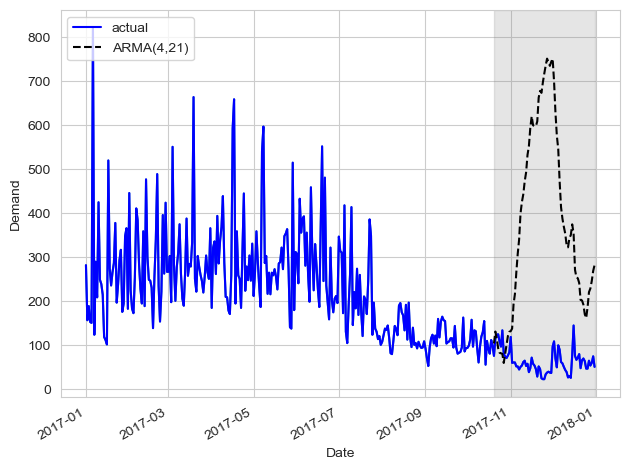

In [36]:
fl.fig_caption("Actual and Predicted Taxi Demand Incorporating ARMA Model Forecasts",
               "Visualizing Actual vs Predicted Taxi Demand Using ARMA(4,21) Model")

fig, ax = plt.subplots()

ax.plot(taxi_demand_df['count'])
ax.plot(taxi_demand_df['count'], 'b-', label='actual')
ax.plot(taxi_demand_df['pred_demand'], 'k--', label='ARMA(4,21)')

ax.legend(loc=2)

ax.set_xlabel('Date')
ax.set_ylabel('Demand')

ax.axvspan('2017-10-20', '2017-12-31', color='#808080', alpha=0.2)

fig.autofmt_xdate()
plt.tight_layout()

In [37]:
mae_ARMA = mean_absolute_error(test['count'], test['pred_ARMA'])
mae_ARMA

61.92201968495215

In [38]:
tf.random.set_seed(150)
np.random.seed(150)

In [39]:
train_df = taxi_demand_df['count'].iloc[:int(len(taxi_demand_df) * 0.64)].to_frame()
val_df = taxi_demand_df['count'].iloc[int(len(taxi_demand_df) * 0.64):int(len(taxi_demand_df) * 0.8)].to_frame()
test_df = taxi_demand_df['count'].iloc[int(len(taxi_demand_df) * 0.8):].to_frame()

scaler = StandardScaler()
scaler.fit(train_df)
train_df_scaled = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns)
train_df_scaled.set_index(train_df.index, inplace=True)

scaler.fit(val_df)
val_df_scaled = pd.DataFrame(scaler.transform(val_df), columns=val_df.columns)
val_df_scaled.set_index(val_df.index, inplace=True)

scaler.fit(test_df)
test_df_scaled = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)
test_df_scaled.set_index(test_df.index, inplace=True)

In [40]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df_scaled, val_df=val_df_scaled, test_df=test_df_scaled, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='count', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (days)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [41]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [42]:
wide_window = DataWindow(input_width=21, label_width=21, shift=1, label_columns=['count'])

In [43]:
lstm_model = Sequential([LSTM(32, return_sequences=True), Dense(units=1)])

In [44]:
history = compile_and_fit(lstm_model, wide_window)

val_performance = {}
performance = {}

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.8630 - mean_absolute_error: 0.6877 - val_loss: 1.0546 - val_mean_absolute_error: 0.8344
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8598 - mean_absolute_error: 0.6913 - val_loss: 1.0608 - val_mean_absolute_error: 0.8408
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8524 - mean_absolute_error: 0.6897 - val_loss: 1.1331 - val_mean_absolute_error: 0.8538
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8415 - mean_absolute_error: 0.6863 - val_loss: 1.1421 - val_mean_absolute_error: 0.8659
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1382 - mean_absolute_error: 0.8644 


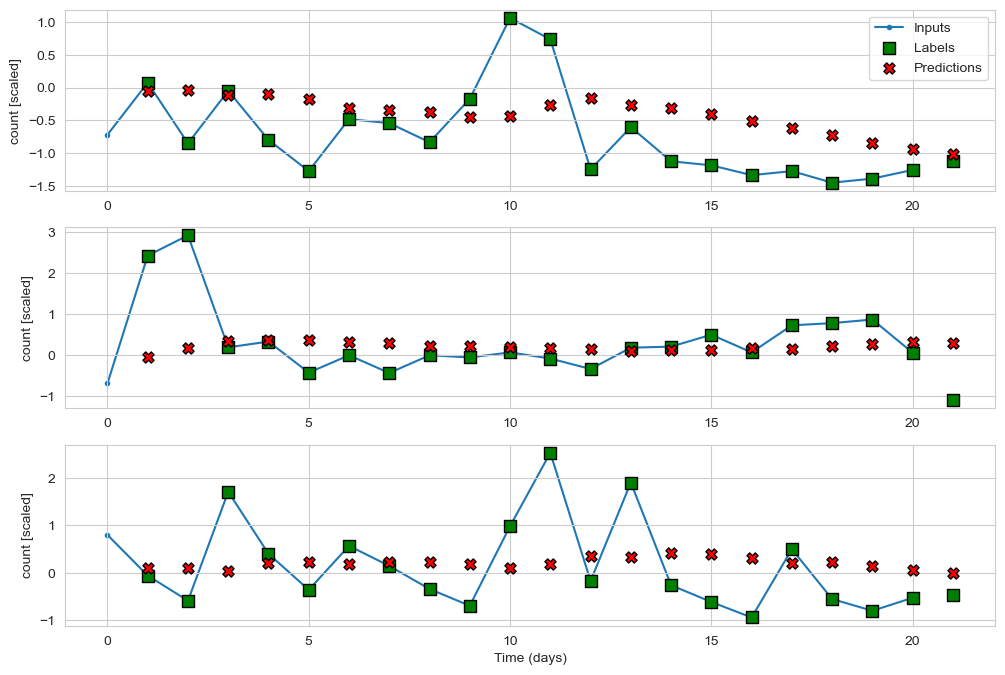

In [45]:
fl.fig_caption("LSTM Model Predictions on Wide Window",
               "Plotting LSTM Model Predictions on a Wide Window")

wide_window.plot(lstm_model)

[ref]: #top
[Back to Table of Contents][ref]

<a name="res_dis"></a>
## Results and Discussions
***

**Taxi Demand Patterns:**
The taxi demand by hour and day graphs indicate clear patterns of taxi usage, with demand peaking at specific hours each day. This hourly fluctuation is vital for any forecasting model as it reflects the real-world behavior of taxi usage.
Time Series and Differencing:
The time series plots for the entire year and the first differences highlight the variability in the taxi demand data. The first difference transformation, which is reflected in the SARIMAX model as the 'Integrated' part of ARIMA, helps stabilize the mean of the time series by removing changes in the level of a time series, making it stationary.

**ARMA(4,21) Model Evaluation:**
The AIC table and the SARIMAX results with the selected ARMA(4, 21) model coefficients provide insights into the lags of past data that are most informative for predicting future data points. The diagnostic checks, including the Ljung-Box test, suggest that the residuals from the model do not show significant autocorrelation, which implies that the model has adequately captured the information in the data.

**Comparison with Actual Data:**
The plots comparing the actual and forecasted demand using the ARMA(4,21) model indicate the model's ability to follow the general movement of the data after differencing. However, they also reveal that the model may only capture some nuances, particularly the sharp increases or decreases in demand.
Deep Learning Model Insights:
Deep learning model predictions show a closer fit to the actual labels, suggesting that such models are more effective for capturing complex patterns. The model may be picking up on intricate structures in the data that are not explicitly modeled in ARMA-type models.

**The  analysis of the time series data and predictive models suggests that:**

The ARMA(4,21) model captures the autocorrelation structure of the data to some extent but might only partially account for some of the underlying dynamics, as indicated by the forecasted plots.

Deep learning models show promise in capturing more complex patterns and may provide a more accurate forecast, as indicated by the comparison with actual labels.

The SARIMAX model coefficients and diagnostics suggest that the model has incorporated significant lags and moving average terms effectively to capture the autocorrelation in the data.

Improvement in forecasting accuracy may be achieved by further tuning the ARMA model or using more advanced machine learning techniques, which may be better suited for capturing non-linear patterns and interactions that traditional time series models do not address.

[ref]: #top
[Back to Table of Contents][ref]

<a name="conc"></a>
## Conclusion and Recommendations
***

**Conclusion:**

The comparative analysis of the taxi demand data using the ARMA(4,21) model and a deep learning approach has revealed distinct insights. The ARMA(4,21) model, while capturing autocorrelations effectively, does not encapsulate all the variability present in the taxi demand data, particularly failing to predict sharper fluctuations. On the other hand, the deep learning model shows a promising ability to forecast taxi demand more accurately by possibly capturing more complex patterns. Nonetheless, the robustness and generalizability of this model need to - be thoroughly tested.

**Recommendations:**

*Model Enhancement:*
Refine the deep learning model by experimenting with different architectures and tuning hyperparameters to improve its ability to forecast extreme values without overfitting.

*Feature Engineering:*
Investigate the inclusion of additional features such as weather conditions, traffic data, and local events, which could provide more context to the models and potentially improve predictive performance.

*Hybrid Modeling:*
Explore the development of hybrid models that combine the strengths of statistical approaches like ARMA with deep learning techniques to improve overall forecast accuracy.

*Validation and Testing:*
Implement a rigorous validation strategy using rolling forecast origin techniques to assess model performance over multiple time periods, ensuring stability and reliability.

*Operational Integration:*
Prepare for the operational integration of the chosen predictive model by setting up a pipeline that includes real-time data ingestion, model updating, and anomaly detection mechanisms to maintain high forecasting accuracy.

By following these recommendations, you can aim to create a more accurate and robust system for predicting taxi demand, which is crucial for effective resource allocation and strategic planning in the transportation sector.


[ref]: #top
[Back to Table of Contents][ref]

***
***